In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# same batch generator and vgg16 model

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
K.set_image_data_format('channels_first')

def get_batches(dirname, gen=ImageDataGenerator(), batch_size=32, shuffle=True, class_mode='categorical'):
    return gen.flow_from_directory(dirname, target_size=(224, 224), batch_size=batch_size, shuffle=shuffle, class_mode=class_mode)

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Flatten, Dropout
from keras.layers.convolutional import ZeroPadding2D, Conv2D
from keras.layers.pooling import MaxPooling2D

VGG_MEAN = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))
def preprocessing(img):
    img = img - VGG_MEAN
    return img

model = Sequential()
model.add(Lambda(preprocessing, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
# Layer 1
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 2
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 3
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 4
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 5
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))
model.load_weights('vgg16_tf.h5')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

# save vgg16's prediction

In [6]:
training_batches = get_batches('training', shuffle=False, batch_size=1, class_mode=None)
training_data = np.concatenate([training_batches.next() for i in range(training_batches.samples)])
validation_batches = get_batches('validation', shuffle=False, batch_size=1, class_mode=None)
validation_data = np.concatenate([validation_batches.next() for i in range(validation_batches.samples)])

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [7]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [8]:
save_array('training_data.bc', training_data)
save_array('validation_data.bc', validation_data)

In [10]:
training_data = load_array('training_data.bc')
validation_data = load_array('validation_data.bc')

In [11]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [12]:
validation_classes = validation_batches.classes
training_classes = training_batches.classes
validation_labels = onehot(validation_classes)
training_labels = onehot(training_classes)

In [13]:
training_features = model.predict(training_data, batch_size=64, verbose=1)
validation_features = model.predict(validation_data, batch_size=64, verbose=1)

2500/2500 [==============================] - 44s    


In [14]:
save_array('train_lastlayer_features.bc', training_features)
save_array('valid_lastlayer_features.bc', validation_features)

In [15]:
training_features = load_array('train_lastlayer_features.bc')
validation_features = load_array('valid_lastlayer_features.bc')

# second layer model

In [16]:
from keras.optimizers import Adam, RMSprop
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
lm.fit(training_features, training_labels, epochs=10, batch_size=64, validation_data=(validation_features, validation_labels))

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 1s - loss: 0.1272 - acc: 0.9543 - val_loss: 0.0872 - val_acc: 0.9680
Epoch 2/10
22500/22500 [==============================] - 1s - loss: 0.1107 - acc: 0.9624 - val_loss: 0.0918 - val_acc: 0.9700
Epoch 3/10
22500/22500 [==============================] - 1s - loss: 0.1106 - acc: 0.9636 - val_loss: 0.0993 - val_acc: 0.9724
Epoch 4/10
22500/22500 [==============================] - 1s - loss: 0.1125 - acc: 0.9647 - val_loss: 0.0987 - val_acc: 0.9696
Epoch 5/10
22500/22500 [==============================] - 1s - loss: 0.1158 - acc: 0.9654 - val_loss: 0.1055 - val_acc: 0.9728
Epoch 6/10
22500/22500 [==============================] - 1s - loss: 0.1152 - acc: 0.9656 - val_loss: 0.1117 - val_acc: 0.9684
Epoch 7/10
22500/22500 [==============================] - 1s - loss: 0.1178 - acc: 0.9662 - val_loss: 0.1162 - val_acc: 0.9692
Epoch 8/10
22500/22500 [==============================] - 1s -

In [22]:
lm.save_weights('vgg16_tf_finetune1.h5')
lm.load_weights('vgg16_tf_finetune1.h5')
lm.evaluate(validation_features, validation_labels)

2144/2500 [========================>.....] - ETA: 0s

[0.12486268732496537, 0.96760000000000002]

In [25]:
preds = lm.predict_classes(validation_features, batch_size=64)
probs = lm.predict_proba(validation_features, batch_size=64)[:,0]
preds[:8], probs[:8]

2500/2500 [==============================] - 0s     


(array([0, 0, 0, 0, 1, 0, 0, 1]),
 array([ 1.        ,  1.        ,  1.        ,  1.        ,  0.03927961,
         1.        ,  1.        ,  0.2794778 ], dtype=float32))

# check result

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_classes, preds)
print(cm)
print(validation_batches.class_indices)

[[1203   47]
 [  34 1216]]
{'cat': 0, 'dog': 1}


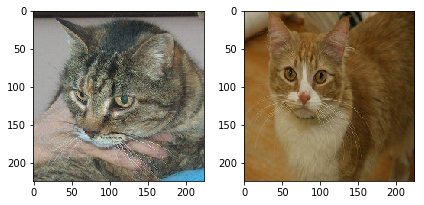

In [44]:
correct = np.where(preds==validation_labels[:, 1])[0]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.rollaxis(validation_data[correct[0]], 0, 3).astype(np.uint8))
ax2.imshow(np.rollaxis(validation_data[correct[1]], 0, 3).astype(np.uint8))
plt.tight_layout()

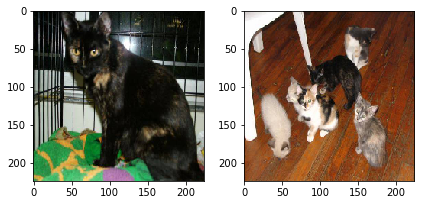

In [50]:
incorrect = np.where(preds!=validation_labels[:, 1])[0]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.rollaxis(validation_data[incorrect[0]], 0, 3).astype(np.uint8))
ax2.imshow(np.rollaxis(validation_data[incorrect[1]], 0, 3).astype(np.uint8))
plt.tight_layout()

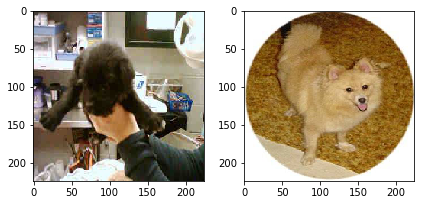

In [52]:
incorrect = np.where((preds==0)&(preds!=validation_labels[:, 1]))[0]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.rollaxis(validation_data[incorrect[0]], 0, 3).astype(np.uint8))
ax2.imshow(np.rollaxis(validation_data[incorrect[1]], 0, 3).astype(np.uint8))
plt.tight_layout()

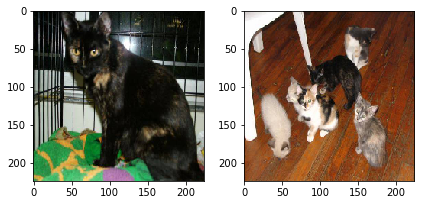

In [48]:
incorrect = np.where((preds==1)&(preds!=validation_labels[:, 1]))[0]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.rollaxis(validation_data[incorrect[0]], 0, 3).astype(np.uint8))
ax2.imshow(np.rollaxis(validation_data[incorrect[1]], 0, 3).astype(np.uint8))
plt.tight_layout()

[ 0.55217409  0.58169603  0.58907562  0.59420151  0.60545921  0.63989884
  0.65167511  0.66118252  0.68957788  0.70711809]


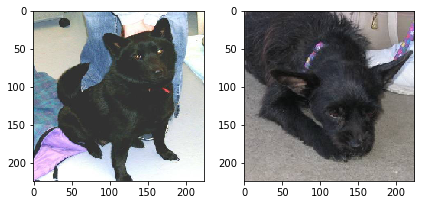

In [75]:
incorrect_cats = np.where((preds==0) & (preds!=validation_labels[:,1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.rollaxis(validation_data[incorrect_cats][most_incorrect_cats[0]], 0, 3).astype(np.uint8))
ax2.imshow(np.rollaxis(validation_data[incorrect_cats][most_incorrect_cats[1]], 0, 3).astype(np.uint8))
plt.tight_layout()
print(probs[incorrect_cats][most_incorrect_cats[:10]])

[ 0.46757883  0.44373176  0.4220019   0.41529426  0.39745051  0.34807864
  0.33741876  0.33707011  0.33359584  0.31636879]


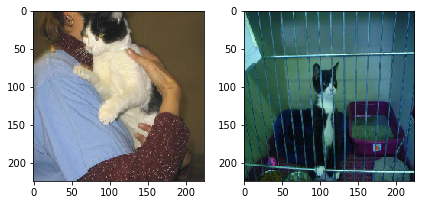

In [78]:
incorrect_dogs = np.where((preds==1) & (preds!=validation_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.rollaxis(validation_data[incorrect_dogs][most_incorrect_dogs[0]], 0, 3).astype(np.uint8))
ax2.imshow(np.rollaxis(validation_data[incorrect_dogs][most_incorrect_dogs[1]], 0, 3).astype(np.uint8))
plt.tight_layout()
print(probs[incorrect_dogs][most_incorrect_dogs[:10]])